<img src="ost_logo.png" width="240" height="240" align="right"/>
<div style="text-align: left"> <b> Machine Learning </b> <br> MSE FTP MachLe <br> 
<a href="mailto:christoph.wuersch@ost.ch"> Christoph Würsch </a> </div>

# Lab07: A4 Free Spoken Digits Classification (FSDD dataset)

In this notebook, we introduce a possible approach to the *Free Spoken Digit Dataset* classification problem.  
The machine learning models are able to predict audio labels with an accuracy of 98%. 

This notebook was inspired by: [Inam ur Rehman](https://www.kaggle.com/iinaam), Data Analyst at PIC - Servizi per l'informatica, Turin, Piedmont, Italy


## In particular
we shall see:
1. How to play audio files in Python
2. How to sample audio signal into digital form
3. How to remove leading and trailing noise (e.g. silence) from audio
4. How to set a naive baseline (use of time domain)
5. How to combine time and frequency domain features (Spectogram)
6. How to train, build and predict using different machine learning models

### Import Necessary Libraries

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join
from scipy.io import wavfile

import IPython.display as ipd
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim

# plotting utilities
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.titleweight"] = 'bold' 
plt.rcParams["figure.titlesize"] = 'large'
plt.rcParams['figure.dpi'] = 120
#plt.style.use('fivethirtyeight')

rs = 99

### Load data

- The Free Spoken Digit Dataset is a collection of audio recordings of utterances of digits (“zero” to “nine”) from different people.  
- You can download the dataset [here](https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd): https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd
- Download the data an your local drive and set the directory path accordingly.

The goal of this competition is to correctly identify the digit being uttered in each recording.


In [10]:
files = '../V07_Feature_Engieering (notebook_templates)/recordings'
ds_files = listdir(files)

X = []
y = []
for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    X.append(data.astype(np.float16))
    y.append(label)

In [11]:
len(X), len(y)

(3000, 3000)

# Basic EDA

### (a) Analyze whether the dataset is well balanced.

In [12]:
np.unique(y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([300, 300, 300, 300, 300, 300, 300, 300, 300, 300]))

The problem is well balanced: for each of the classes we have 300 samples in dataset.  
All recordings are sampled at the rate of 8 kHZ

Audio signals have different length.  
Some of them have leading and silence intervals. Let's analyze that first.

### (b) Plot a histogram of the length of the spoken words.

- What is the average length of the spoken words?
- what is the standard deviation of the length of the words?
- What is the 90% percentile of the length of the records?
- What is the number of outliers that excede the 90% quantile?


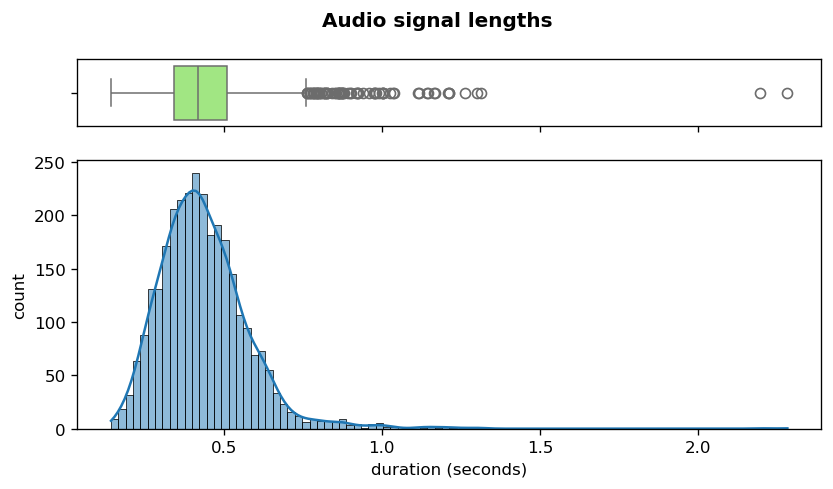

In [13]:
rate = 8000
def show_length_distribution(signals, rate = 8000):
    sampel_times = [len(x)/rate for x in signals]


    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    # Add a graph in each part
    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')


    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times


lengths = show_length_distribution(X)

In [14]:
np.mean(lengths)

0.4374343333333333

In [15]:
np.std(lengths)

0.14761839633964627

In [16]:
q = 90
np.percentile(lengths, q)

0.604525

In [17]:
tot_outliers = sum(map(lambda x: x > np.percentile(lengths, q), lengths))
print(f'Values outside {q} percentile: {tot_outliers}')

Values outside 90 percentile: 300


These outliers will be later handled according to the proposed solutions.  

### (c) Play and display one of the records.

Have a look at some extreme cases. Use `IPython.display.ipd` to display and play the audio signal.
- Look at the longest signal
- look at the shortest signal


In [18]:
Longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[Longest_audio])
plt.title("Longest audio signal");

plt.grid(True)
plt.xlabel('sample')
plt.ylabel('amplitude (arb.)')
ipd.Audio(X[Longest_audio], rate=rate)


In [19]:
Shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[Shortest_audio])
plt.title("Shortest audio signal");

plt.grid(True)
plt.xlabel('sample')
plt.ylabel('amplitude (arb.)')
ipd.Audio(X[Shortest_audio], rate=rate)


# Time domain analysis
###  (d) Feature Extraction from time domain

- Remove the leading and trailing silence from signals to see if we get different distribution of length. 
- Use `from librosa.effects import trim` to trim the signals. By default anything below 10 db is considered as silence.

In [20]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

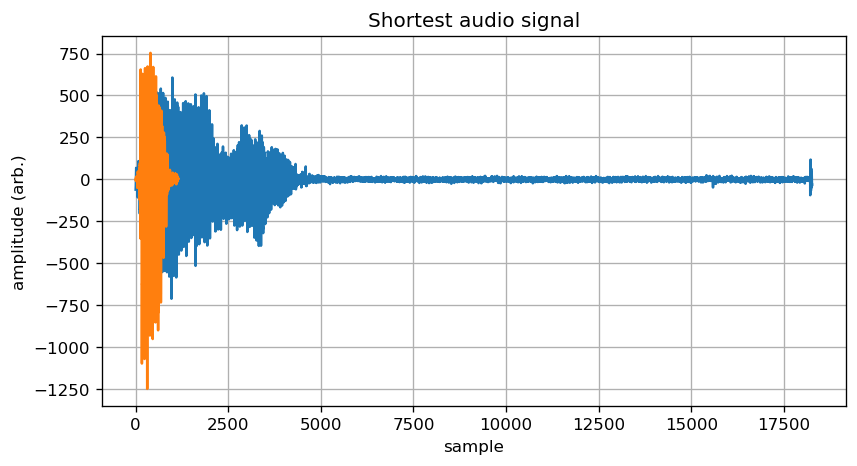

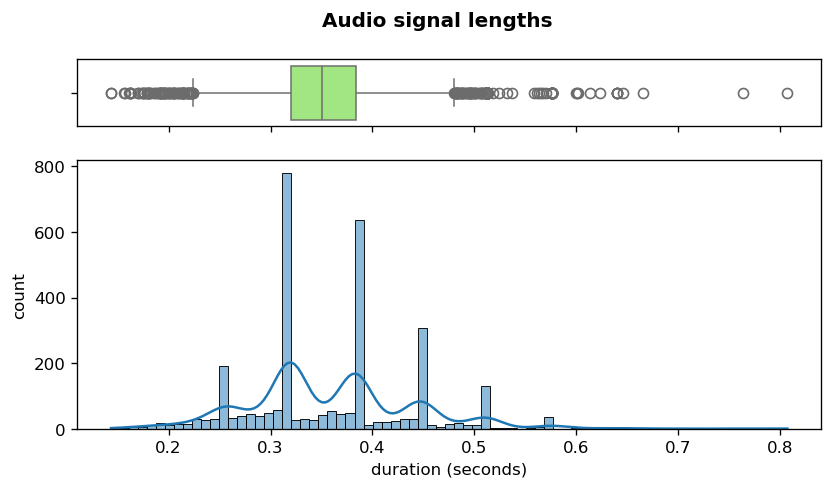

In [21]:
X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr);

We can explore different recordings to see how they are trimmed.

In [22]:
plt.plot(X_tr[Longest_audio])
plt.title("Longest recording after trimming");

plt.grid(True); plt.xlabel('sample'); plt.ylabel('amplitude (arb.)')
ipd.Audio(X_tr[Longest_audio], rate=rate)

### (e) Create a matrix with uniform length of columns to allign all recordings.  

- All signals should have `rate*0.8=6400` data points.

In [23]:
N = int(rate * 0.8) # 0.8 is the upper limit of trimmed audio length
print(N)

6400


In [24]:
X_uniform = []
for x in X_tr:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])

### (f) Audio feature generation

- Write a function that creates bins of same width and computes mean and standard deviation on those bins as features for audio classification.


In [25]:
def into_bins(X, bins = 20):
    """This functions creates bins of same width and computes mean and standard deviation on those bins
    """
    X_mean_sd = []
    for x in X:
        x_mean_sd = []
        As = np.array_split(np.array(x), 20)
        for a in As:
            mean = np.round(a.mean(dtype=np.float64), 4)
            sd = np.round(a.std(dtype=np.float64), 4)
            x_mean_sd.extend([mean, sd])

        X_mean_sd.append(x_mean_sd)
    return np.array(X_mean_sd)

### (g) Random Forest classifier on the time domain features

- Train a random forest clasifier on the dataset consisting of the mean and the standard deviation of the bins.
- Hypertune the random forest classifier using a grid search over the following parameters:

In [26]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Number of bins is an hyperparameter.  
We will try different n. of bins with default configurations of Random Forest Classifier.

In [27]:
for bins in range(20,101,20):
    X_mean_sd = into_bins(X_uniform, bins)
    X_train, X_test, y_train, y_test = train_test_split(X_mean_sd, y, test_size = 0.20, random_state = rs)
    clf = RFC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
    print(f"for {bins} bins, f-macro average:{f.mean()}, accuracy: {acc}")

for 20 bins, f-macro average:0.5919620221247721, accuracy: 0.5983333333333334
for 40 bins, f-macro average:0.5757717910861361, accuracy: 0.5833333333333334
for 60 bins, f-macro average:0.5743036878306336, accuracy: 0.5833333333333334
for 80 bins, f-macro average:0.5682723467174141, accuracy: 0.5766666666666667
for 100 bins, f-macro average:0.5917362413751577, accuracy: 0.5983333333333334


With 60 bins we are able to get comparable results.  
Now we will train two models via grid search to optimize the configuration.

####  Hyperperameter tuning

In [ ]:
X_time = into_bins(X_uniform, 60)
X_train, X_test, y_train, y_test = train_test_split(X_time, y, test_size = 0.20, random_state = rs)

### Random Forest Classifier

In [ ]:
param_grid = {
    "n_estimators": [100,150,200],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.05,0.1]
}

clf = RFC(random_state = rs, n_jobs = -1 )
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 5)
grid_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", grid_search.best_params_)
print("best score:", grid_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


# Spectral Features

In a spectoral representation of audio signals, we get time on x-axis and different frequencies on y-axis.
Values in the matrix represent different properties of audio singal related to particular time and frequency. (amplitude, power ecc)

### (h) Plot a power spectrogram of an arbitrary sound sample spectrogram on log scale (dB)

- Plot a power spectrogram of an arbitrary sound sample spectrogram on log scale (dB)
- use `powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(X[...], Fs=rate, scale = "dB")`


In [ ]:
# Plot the spectrogram of power on log scale

# fig, ax = plt.subplots(figsize = (8,6))

powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(X[np.random.randint(100)], Fs=rate, scale = "dB")
cbar = plt.gcf().colorbar(imageAxis)
cbar.set_label('db')
plt.grid()
plt.suptitle("Spectrogram of a signal")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()   

### (i) Feature extraction from MEL spectogram

We have seen that both time and frequency domains contain useful information regarding the recordings.  
We can leverage both by using the spectrogram of each signal.
  
To extract features from a MEL spectrogram of given signal, we divide it into `N x N` sub matrices of nearly identical shape.  
- Compute the *mean* and *standard deviation* of these submatrices and consider them as features set.  
- The number `N` of sub matrices is considered as an *hyperparameter* for the classifier.
- You can use the helper function `ft_mean_std(X, n, f_s = 8000)` to do this.

In [ ]:
def ft_mean_std(X, n, f_s = 8000):
    """Computes mean and std of each n x n block of spectrograms of X
       empty bins contains mean values of that column matrices
       
    Parameters:
        X: 2-d sampling array
        n: number of rows or columns to split spectogram
    Returns:
        A 2-d numpy array - feature Matrix with n x 2 x n features as columns
    """
    X_sp = [] #feature matrix
    for x in X:
        sp = power_to_db(melspectrogram(y=x, n_fft= len(x)))
        x_sp = [] #current feature set
        # split the rows
        for v_split in np.array_split(sp, n, axis = 0):
            # split the columns
            for h_split in np.array_split(v_split, n, axis = 1):
                if h_split.size == 0: #happens when number of culumns < n
                    m = np.median(v_split).__round__(4)
                    sd = np.std(v_split).__round__(4)
                else:
                    m = np.mean(h_split).__round__(4)
                    sd = np.std(h_split).__round__(4)
                x_sp.extend([m,sd])
                
        X_sp.append(x_sp)

    return np.array(X_sp)

In [ ]:
X_ft = ft_mean_std(X, 10)
len(X_ft)

## Hyperparameter tuning

### (j) Determine the optimum number `N` of bins
- Determine the optimum number `N` of bins in time-frequency domain (`N` along the time dimension and `N` along the frequency dimension).
- Program a for loop that varies `N` in the `range(3,20,2)` and train a Random Forest Classifier on the training set (80%) and validate it on the validation set (20%).
- Select the optimum number of bins `N`

In [ ]:
models = {"rfc": RFC(random_state=rs, n_jobs=-1)}
scores = {}
for n in range(3,20,2):
    X_ft = ft_mean_std(X, n)
    X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size = 0.20, random_state = rs)
    score = []
    for model in models:
        clf = models[model]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
        score.append((model, np.mean(f)))
    scores[n] = score

In [ ]:
rf_scores = [x[0][1] for x in scores.values()]
x = scores.keys()

plt.plot(x, rf_scores, 'o-', label = 'RF')
plt.grid(True)
plt.legend(loc = (1,.8))
plt.suptitle("Model evaluation on different n. of bins")
plt.xlabel("n. of bins")
plt.ylabel('mean f-score')
plt.show()

We can select 10 as initial number of bins. Both models are stable in the neighborhood of 10.  
we can check the performance of models with their optimal configurations.


In [ ]:
X_ft = ft_mean_std(X, 10)
X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size = 0.20, random_state = rs)

# Classification models

### (k) Hypertune a Random Forest Classifier 
- Hypertune a Random Forest Classifier using `N=10` bins using a 5-fold crossvalidation with the following grid search:

In [ ]:
param_grid = {
    "n_estimators": [100,150,200],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.05,0.1]
}

clf = RFC(random_state = rs, n_jobs = -1 )
rf_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 5)
rf_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", rf_search.best_params_)
print("best score:", rf_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = rf_search.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
rfc = RFC(n_estimators= 200, criterion= 'gini', min_impurity_decrease= 0.0,random_state = rs, n_jobs = -1 )
scores = cross_val_score(rfc, X_ft, y, cv=10, scoring = 'accuracy', n_jobs = -1)
report = f"""Average accuracy of Random Forest model: {np.mean(scores):.2f}
with a standard deviation of {np.std(scores):.2f}
"""
print(report)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Appendix (optional)

Although results are quite satisfactory, we can use other techniques to split the spectogram matrix.  
One other way of splitting spectorgram is to _pad_ it such that each sub matrix has identical shape.  
This way we also avoid the for-loops which is performance killer. 
- This time, we use a Support Vector Classifier (see lecture 8).


In [ ]:
def split(array,w_bins):
    """Split a matrix into sub-matrices of equal size."""

    # original dimensions
    rows, cols = array.shape
    # size of sub matrices
    sub_rows = rows//w_bins + 1 * rows%w_bins
    sub_cols = cols//w_bins + 1 * cols%w_bins
    # padding to properly fit
    pad_rows = sub_rows*w_bins - rows
    pad_cols = sub_cols*w_bins - cols
    padded_array = np.pad(array, ((0,pad_rows), (0, pad_cols)))
    
    rows, cols = padded_array.shape
    return (padded_array.reshape(rows//sub_rows, sub_rows, -1, sub_cols)
                 .swapaxes(1, 2)
                 .reshape(-1, sub_rows, sub_cols))


def split_ft_mean_std(X, n):
    """ Computes mean and std of each n x n block of spectrograms of X
        bins are padded with zeros to equaly divide in n x n matrices.
        
    Parameters:
        X: 2-d sampling array
        n: number of rows or columns to split spectogram
    Returns:
        A 2-d numpy array - feature Matrix with n x n x 2 features
    """
    f_s = 8000
    X_sp = [] #feature matrix
    for x in X:
        sp = power_to_db(melspectrogram(y=x, n_fft= len(x)))
        blocks = split(sp,n)
        mean = blocks.mean(axis = (-1,-2))
        std = blocks.std(axis = (-1,-2))
        X_sp.append(np.hstack((mean,std)))
    return np.array(X_sp)

In [ ]:
# %timeit -n2 -r1 ft_mean_std(X, 10)

In [ ]:
%timeit -n2 -r1 split_ft_mean_std(X, 10)

As expected, this new method is twice as fast as the previous one.  
Let's compare the results:

In [ ]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC())]
pipeline = Pipeline(steps)

parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"]}


In [ ]:
X_ft = split_ft_mean_std(X, 10)
X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size = 0.20, random_state = rs)

svm_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
svm_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", svm_search.best_params_)
print("best score:", svm_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = svm_search.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC(C= 20, kernel= 'rbf'))]
pipeline = Pipeline(steps)
scores = cross_val_score(pipeline, X_ft, y, cv=10, scoring = 'accuracy', n_jobs = -1)
report = f"""Average accuracy of SVM model: {np.mean(scores):.2f}
with a standard deviation of {np.std(scores):.2f}
"""
print(report)

We get comparable results but model is more efficient now.  
The reuslts can be improved by tuning the appropriate number of splits (as we did earlier).

# Concluisons

The proposed approach obtains results that are outperforming naive baseline we defined in the beginning.  
It does so by leveraging both timeand frequency-based features.  
We have empirically shown that the selected classifiers perform similarly for this specific task, achieving satisfactory results in terms of macro f1 score and accuracy.
We can further improve by using different set of hyperparameters. The results obtained, however, are already very promising. This classification problem is indeed quite easy and the datasets available are very limited.  
 